# **●はじめに**


今回は深層学習の「復習」につき第2回目として、大規模言語モデル（LLM）に向けたアルゴリズムの発展を理解すべく、まずは再帰型ニューラルネットワーク（RNN）、さらにはその発展形であるLSTMの実装を試みる。これらの延長線上においてtransformerがあり、GPT、さらにはLLMがあるわけであるが、その際に重要なのが自然言語処理（natural language processing. NLP）に関する理解である。そこでRNN及びLSTMの実装に入る前に、NLPを巡る基礎的なコードの実装を行い、その流れを復習することにしたい。

# **●自然言語処理（natural language processing, NLP）とは何か？**

自然言語処理（しぜんげんごしょり、英語: Natural language processing、略称：NLP）は、人間が日常的に使っている自然言語をコンピュータに処理させる一連の技術であり、人工知能と言語学の一分野である。「計算言語学」（computational linguistics）との類似もあるが、自然言語処理は工学的な視点からの言語処理をさすのに対して、計算言語学は言語学的視点を重視する手法をさす事が多い。データベース内の情報を自然言語に変換したり、自然言語の文章をより形式的な（コンピュータが理解しやすい）表現に変換するといった処理が含まれる。応用例としては機械翻訳や仮名漢字変換が挙げられる。

In [1]:
#NLPとしては最も基礎的なツールとして、tf-idfの実装を以下では行う。
#なお、tf-idfについてはこちらのwikipedia上の記載を熟読のこと→　https://ja.wikipedia.org/wiki/Tf%E2%80%93idf

#まず以下の文章を例としてカウントしてみる。

corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?'
]

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x = tfidf.fit_transform(corpus)

In [5]:
#tf-idfの計算結果を見るためにDataFrameに転換する。

import pandas as pd

df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
print(df_tfidf)

次に文章同士の類似度をコサイン類似度（cosine similarity）にて計算してみる。大規模言語モデル（LLM）の実装に際しても実は重要な概念となってくるのでよく理解すること。

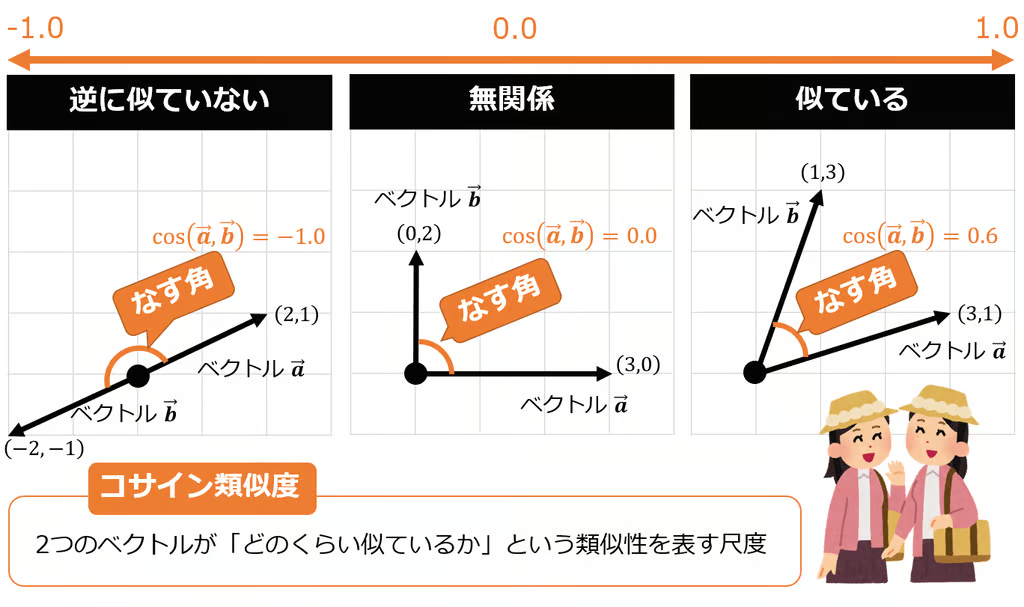

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(x))

**【課題】**

任意の英語の文章4つを用意し、それら相互間のコサイン類似度を計算の上、比較せよ。

次に同じくNLPの基礎的なツールとして**Word2Vec**の原理を理解し、その実装を試みる。Word2Vecについては[こちら](https://ja.wikipedia.org/wiki/Word2vec)を参照すること。

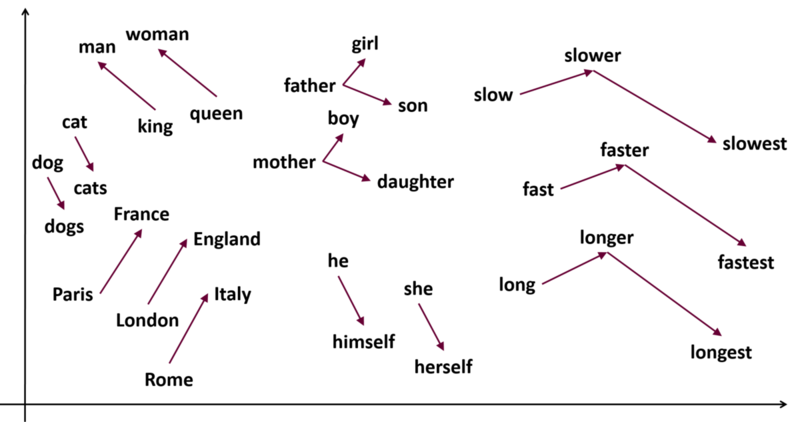

なお自然言語処理において英語等と日本語との間で最も違うのが形態素解析の必要性の有無である。この点については、bag of wordsと併せて、[こちら](https://qiita.com/AwaJ/items/98123d1d3a9bbb6e3e3d)を参考にすること。

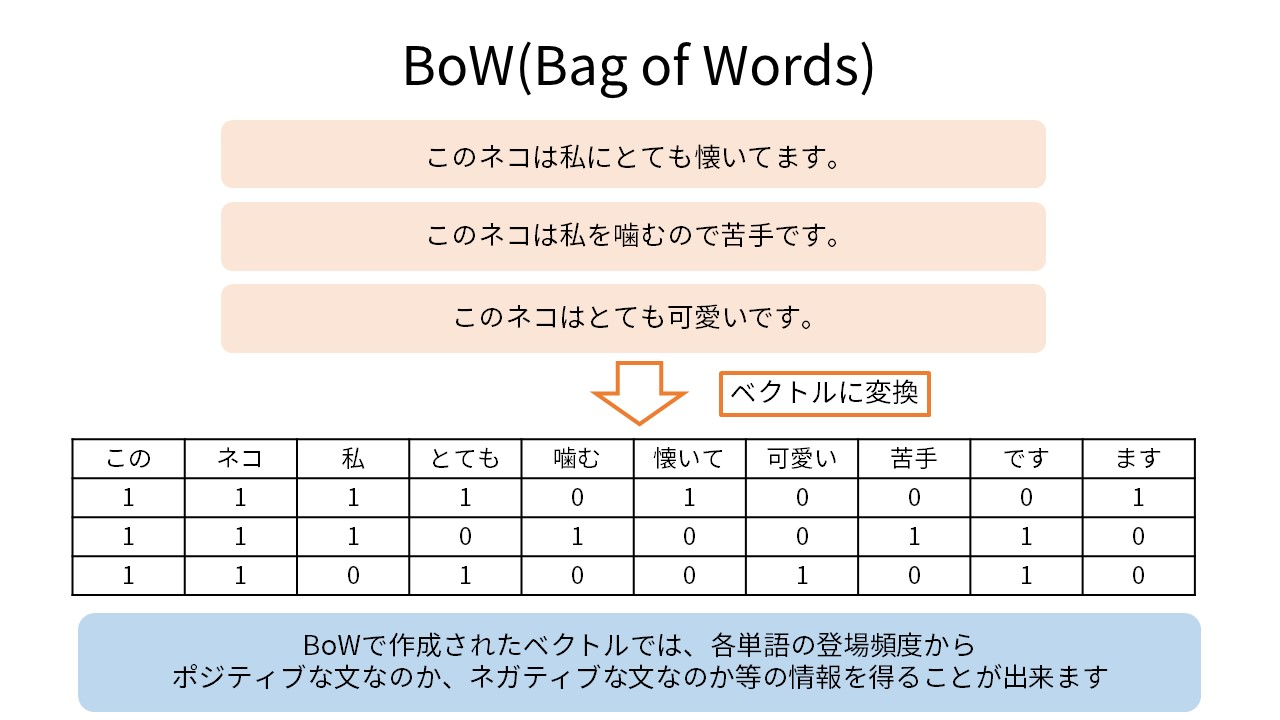

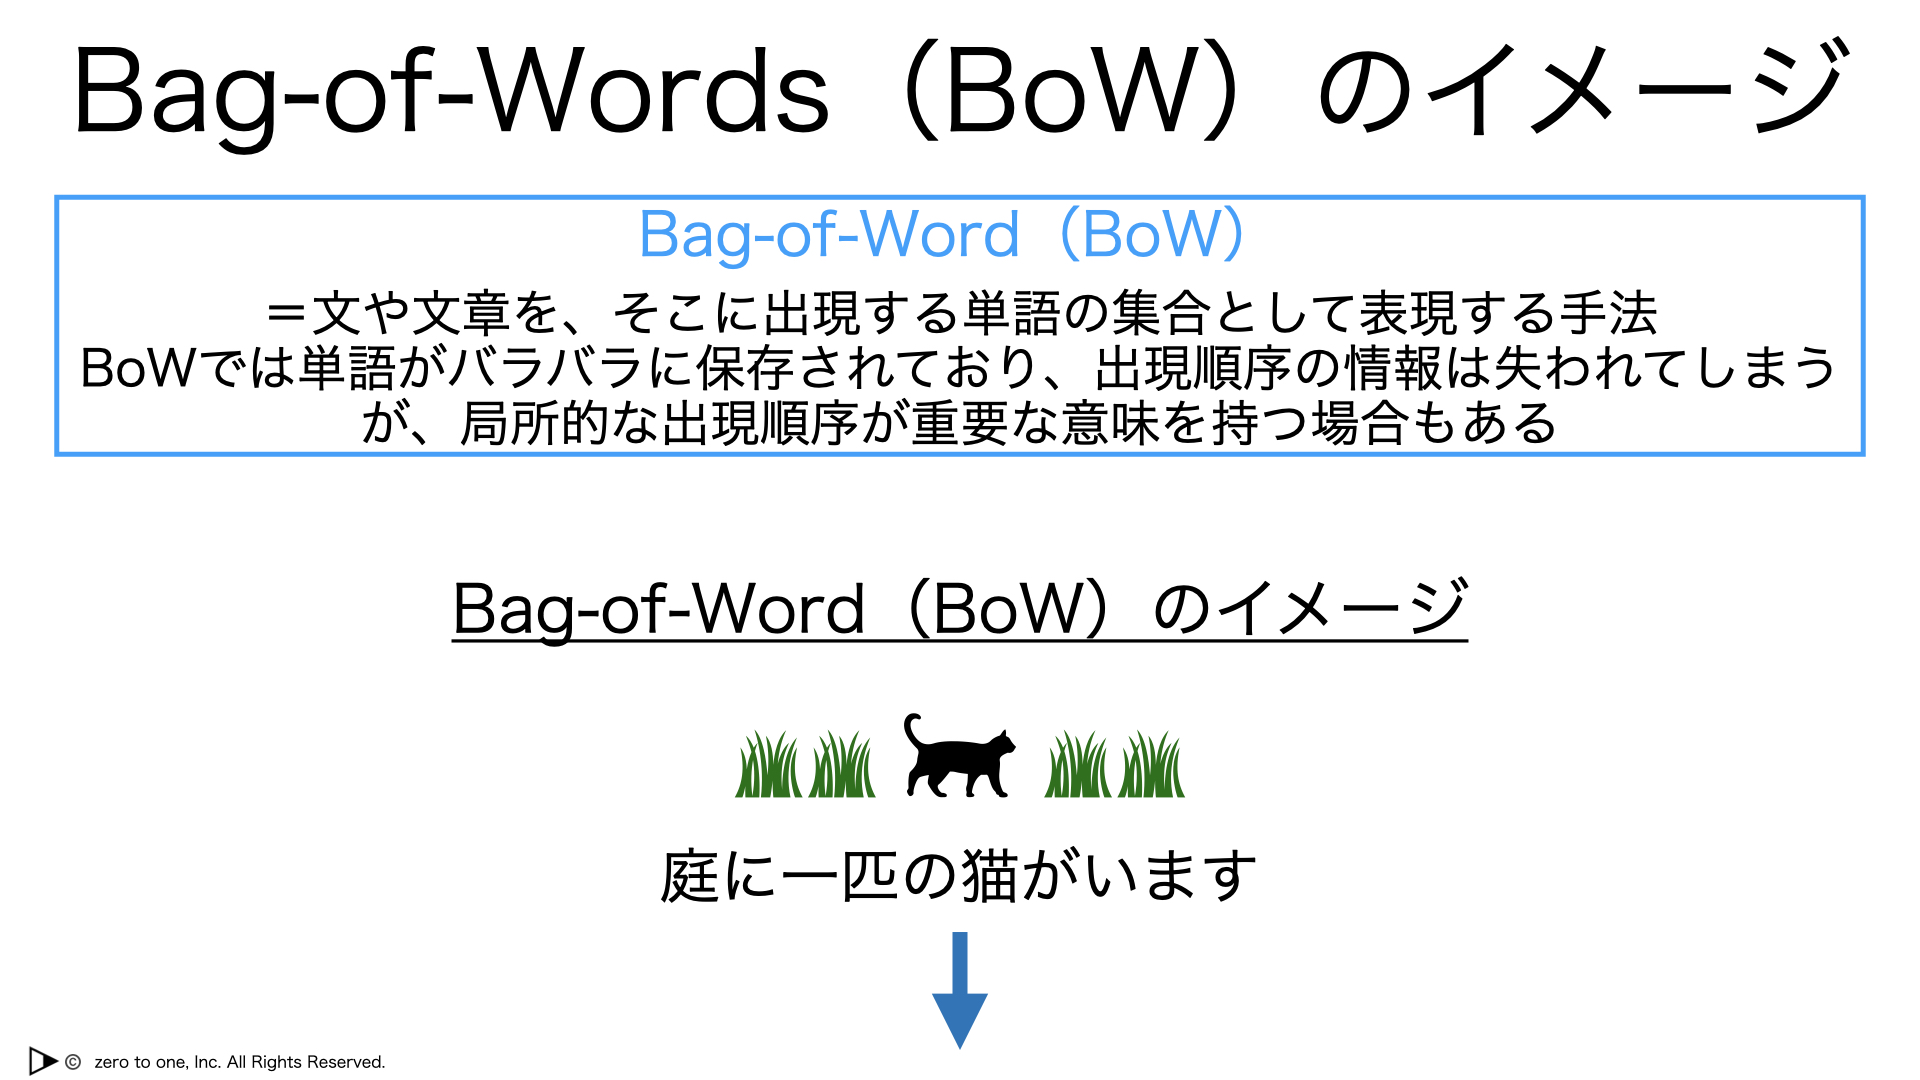



In [ ]:
#以下では形態素解析のためにJanomeを用いつつ、Word2Vecの実装を試みる。

# zipファイルダウンロード
url = 'https://www.aozora.gr.jp/cards/000148/files/794_ruby_4237.zip'
zip = '794_ruby_4237.zip'
import urllib.request
urllib.request.urlretrieve(url, zip)

In [4]:
# ダウンロードしたzipの解凍
import zipfile
with zipfile.ZipFile(zip, 'r') as myzip:
    myzip.extractall()
    # 解凍後のファイルからデータ読み込み
    for myfile in myzip.infolist():
        # 解凍後ファイル名取得
        filename = myfile.filename
        # ファイルオープン時にencodingを指定してsjisの変換をする
        with open(filename, encoding='sjis') as file:
            text = file.read()

In [ ]:
# ファイル整形
import re
# ヘッダ部分の除去
text = re.split('\-{5,}',text)[2]
# フッタ部分の除去
text = re.split('底本：',text)[0]
# | の除去
text = text.replace('|', '')
# ルビの削除
text = re.sub('《.+?》', '', text)
# 入力注の削除
text = re.sub('［＃.+?］', '',text)
# 空行の削除
text = re.sub('\n\n', '\n', text)
text = re.sub('\r', '', text)

# 整形結果確認

# 頭の100文字の表示
print(text[:100])
# 見やすくするため、空行
print()
print()
# 後ろの100文字の表示
print(text[-100:])

In [ ]:
#ここからが形態素解析。

# Janomeのインストール
!pip install janome | tail -n 1

# Janomeのロード
from janome.tokenizer import Tokenizer

# Tokenizerインスタンスの生成
t = Tokenizer()

# テキストを引数として、形態素解析の結果、名詞・動詞・形容詞(原形)のみを配列で抽出する関数を定義
def extract_words(text):
    tokens = t.tokenize(text)
    return [token.base_form for token in tokens
        if token.part_of_speech.split(',')[0] in['名詞', '動詞']]

#  関数テスト
# ret = extract_words('三四郎は京都でちょっと用があって降りたついでに。')
# for word in ret:
#    print(word)

# 全体のテキストを句点('。')で区切った配列にする。
sentences = text.split('。')
# それぞれの文章を単語リストに変換(処理に数分かかります)
word_list = [extract_words(sentence) for sentence in sentences]

# 結果の一部を確認
for word in word_list[0]:
    print(word)

In [ ]:
# Word2Vecライブラリの導入
!pip install gensim

# Word2Vecライブラリのロード
from gensim.models import word2vec

# size: 圧縮次元数
# min_count: 出現頻度の低いものをカットする
# window: 前後の単語を拾う際の窓の広さを決める
# iter: 機械学習の繰り返し回数(デフォルト:5)十分学習できていないときにこの値を調整する
# model.wv.most_similarの結果が1に近いものばかりで、model.dict['wv']のベクトル値が小さい値ばかりの
# ときは、学習回数が少ないと考えられます。
# その場合、iterの値を大きくして、再度学習を行います。

# 事前準備したword_listを使ってWord2Vecの学習実施
model = word2vec.Word2Vec(word_list, vector_size=100,min_count=5,window=5,epochs=100)


In [ ]:
# 一つ一つの単語は100次元のベクトルになっています。
# 「世間」のベクトル値を確認します。
print(model.__dict__['wv']['世間'])


In [ ]:
# 関数most_similarを使って「世間」の類似単語を調べます
ret = model.wv.most_similar(positive=['世間'])
for item in ret:
    print(item[0], item[1])

**【課題】**

青空文庫に収録されている適当な文学作品のテキストを用いてコーパスを作成し、上記と同様に形態素解析を施し、Word2Vecによる処理も行ってみよ。なお形態素解析についてはJanome以外もあるのでその実装も試みよ。

大規模言語モデル（LLM）が一般社会において流布されるに至るより前、自然言語処理（NLP）の”頂点”と言えば、**トピック・モデル（topic modelling）**であった。今となってはアカデミアにおいてもほぼ顧慮されなくなっている感はあるが、NLPにおける一つの金字塔として理解し、実装出来るようになっておくことは重要である。
なお、トピック・モデルについて[こちら](https://en.wikipedia.org/wiki/Topic_model)を参照すること。

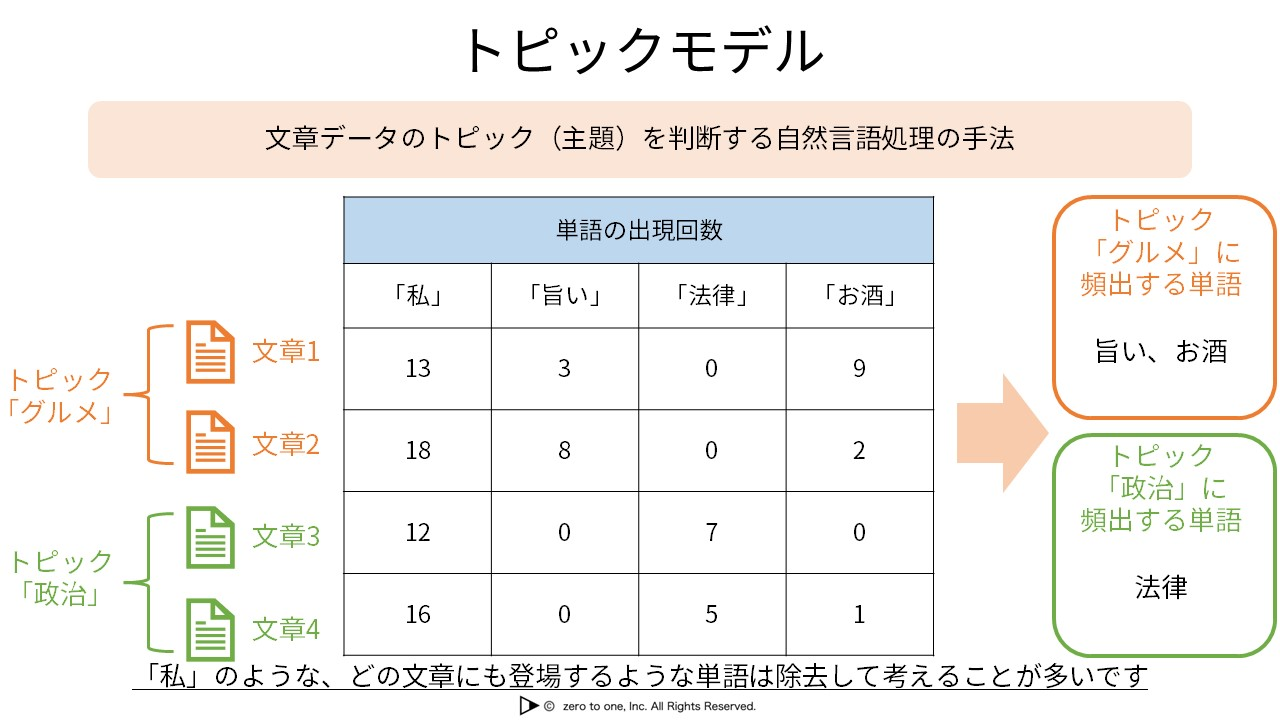



トピック・モデルの中でも潜在的ディリクレ配分法（LDA）が頻用されていた。これについても基礎的な理解をしておくことが非常に重要である。なお、LDAについては[こちら](https://ja.wikipedia.org/wiki/%E6%BD%9C%E5%9C%A8%E7%9A%84%E3%83%87%E3%82%A3%E3%83%AA%E3%82%AF%E3%83%AC%E9%85%8D%E5%88%86%E6%B3%95)及び[こちら](https://qiita.com/K_Noguchi/items/2f0579ca51f5329a4008)を参照すること。

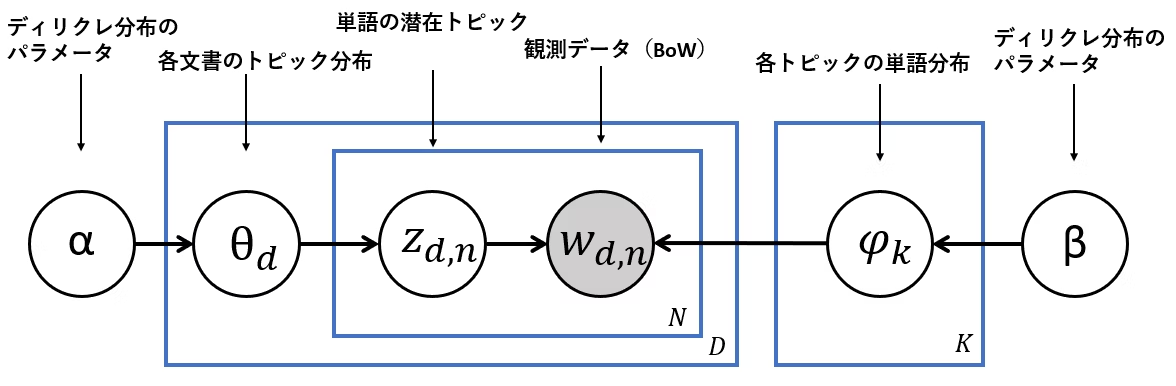

上記を理解するためには共起関係についても理解する必要がある。これについては[こちら](https://japan.zdnet.com/glossary/exp/%E5%85%B1%E8%B5%B7/?s=4)を参照のこと。

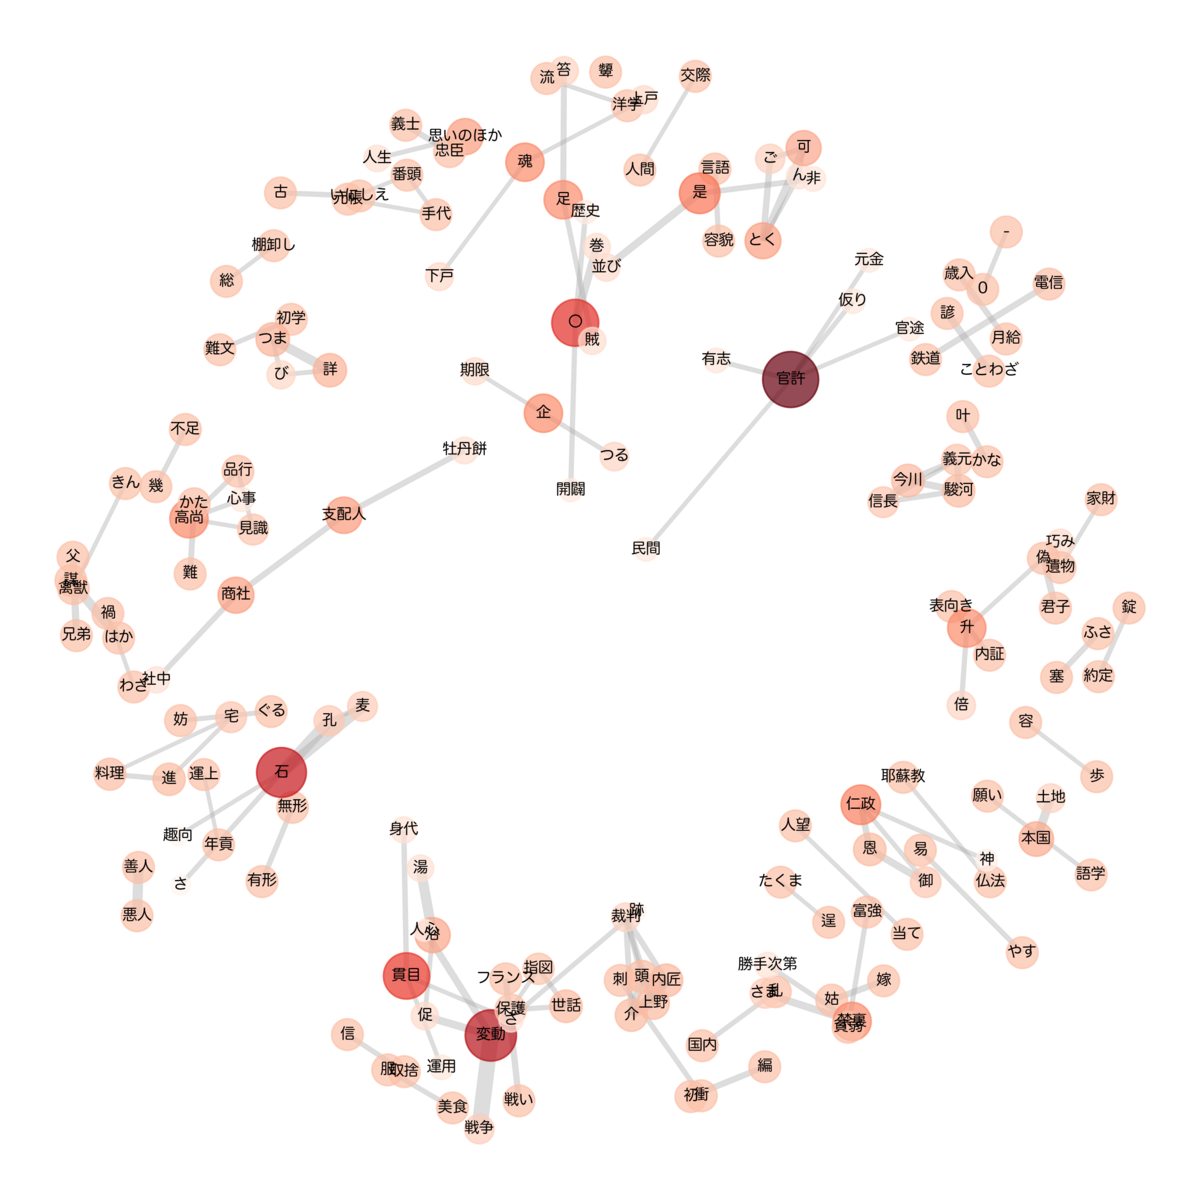

In [ ]:
#以下では9つの英文についてLDAの実装による分析を試みる。

# 必要なライブラリのインポート
from gensim import corpora, models
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# %matplotlib inline for Colab
%matplotlib inline

# 文書とストップワード
documents = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey"
]
stop_words = {
    "the", "and", "of", "to", "in", "for", "a", "an", "on", "at", "by",
    "with", "is", "are", "was", "were", "be", "been", "being", "from"
}
texts = [[word.lower() for word in doc.split() if word.lower() not in stop_words] for doc in documents]

# 辞書・コーパス
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA モデル学習（3トピック）
lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# 各文書のトピック分布と主成分トピック
topic_distributions = []
dominant_topics = []
for doc_bow in corpus:
    dist = lda_model.get_document_topics(doc_bow, minimum_probability=0)
    topic_distributions.append([p for _, p in dist])
    dominant_topics.append(max(dist, key=lambda x: x[1])[0])

# 主成分トピック一覧表示
doc_topics_df = pd.DataFrame({
    'Document': [f'Doc {i+1}' for i in range(len(documents))],
    'Dominant Topic': [f'Topic {t+1}' for t in dominant_topics]
})
print("主成分トピック一覧：")
print(doc_topics_df)

# --- WordCloud描画（フォント未指定） ---
plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    topic_words = dict(lda_model.show_topic(i, topn=30))
    wc = WordCloud(width=600, height=400, background_color='white') \
        .generate_from_frequencies(topic_words)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i+1}")
plt.tight_layout()
plt.show()

# --- PCoAによる2次元プロット ---
coords = MDS(n_components=2, dissimilarity="precomputed", random_state=42) \
    .fit_transform(pairwise_distances(topic_distributions))
colors = ['red', 'green', 'blue']
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(coords):
    plt.scatter(x, y, color=colors[dominant_topics[i]], s=80)
    plt.text(x + 0.01, y + 0.01, f'Doc {i+1}', fontsize=9)
plt.title("PCoA (MDS) with Dominant Topics")
plt.xlabel("PCoA1")
plt.ylabel("PCoA2")
plt.grid(True)
plt.show()


**【課題】**

上記でcoherenceとは何を意味しているのか？調べて説明せよ。

**●再帰型ニューラルネットワーク（recurrenct neural network, RNN）の実装**

再起型ニューラルネットワーク（RNN）とは「ある時点の入力がそれ以降の出力に影響を与える」ニューラルネットワークを指す。
RNNでは過去の連続したデータから学習した結果を次の層の入力として再利用する。
得意分野は「機械翻訳, 言語認識, 文章生成」であり、それ以外でも「時系列を持つ音声/動画解析, 株価予測」などで応用されている。詳細は例えば[こちら](https://ja.wikipedia.org/wiki/%E5%9B%9E%E5%B8%B0%E5%9E%8B%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF)を参照のこと。

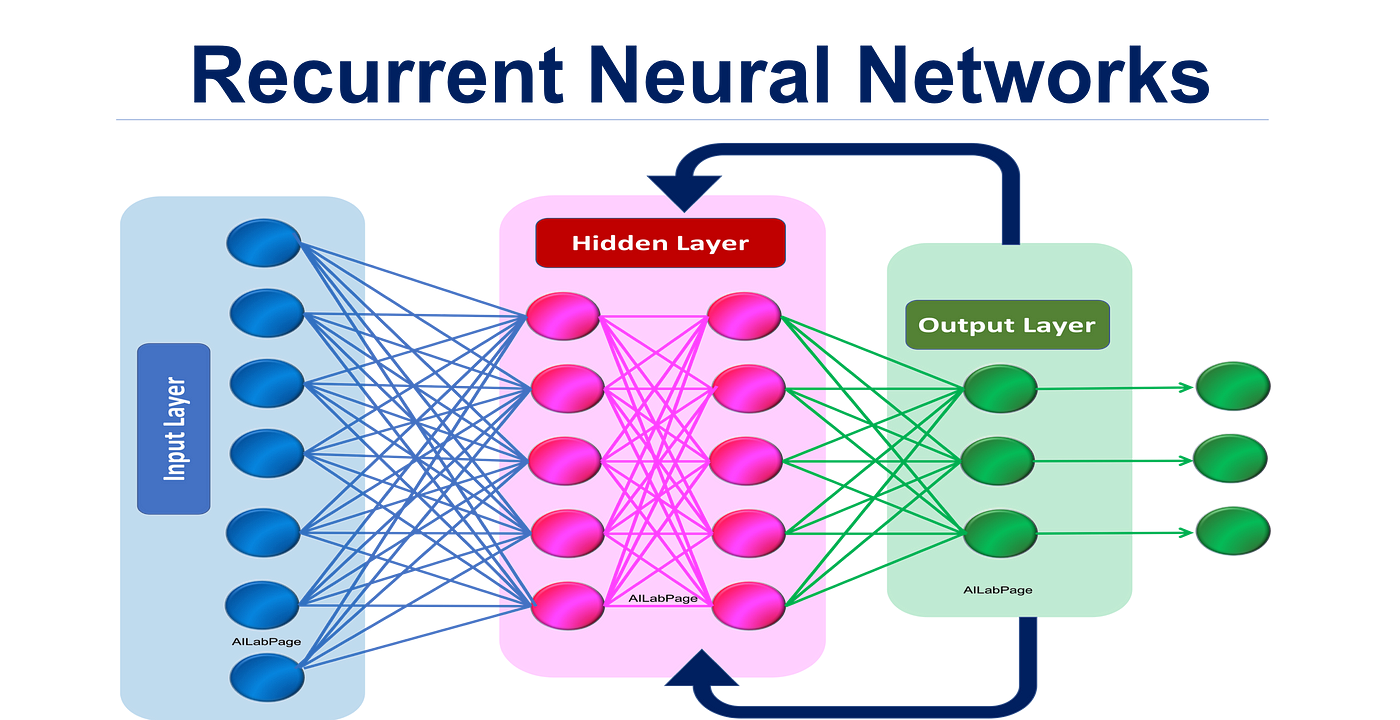

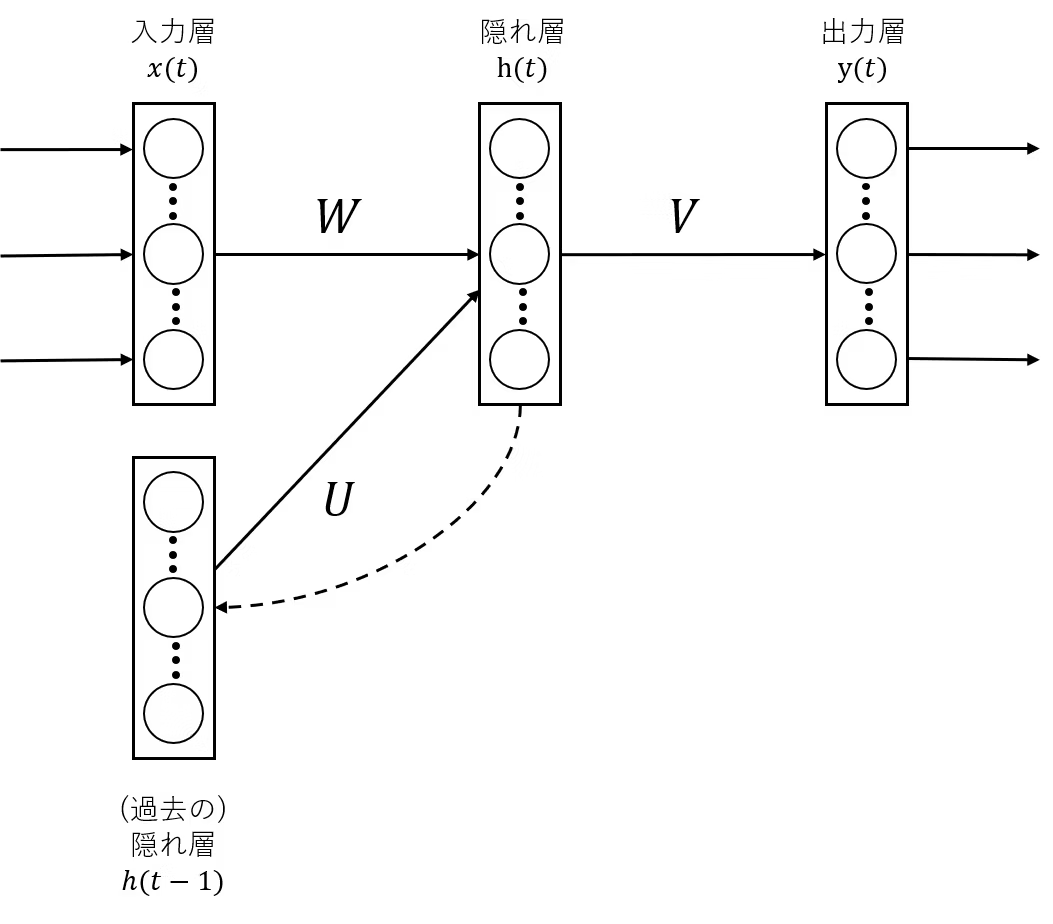

In [ ]:
#以下では再帰型ニューラルネットワーク（RNN）の実装を簡単なコードで試みる。

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optimizers
# from keras.callbacks import EarlyStopping


class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='checkpoint_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する


class RNN(nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = nn.RNN(1, hidden_dim,
                         nonlinearity="tanh",
                         batch_first=True)
        self.l2 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0)

    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:, -1])
        return y


if __name__ == '__main__':

    np.random.seed(123)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    """
    1. データの準備
    """

    def sin(x, T=100):
        return np.sin(2.0 * np.pi * x / T)

    def toy_problem(T=100, ampl=0.05):
        x = np.arange(0, 2*T + 1)
        noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
        return sin(x) + noise

    T = 100
    f = toy_problem(T).astype(np.float32)
    length_of_sequences = len(f)

    maxlen = 25

    x = []
    t = []

    for i in range(length_of_sequences - maxlen):
        x.append((f[i:i+maxlen]))
        t.append(f[i+maxlen])

    x = np.array(x).reshape(-1, maxlen, 1)
    t = np.array(t).reshape(-1, 1)

    x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)

    """
    2. モデルの構築
    """
    model = RNN(50).to(device)

    """
    3. モデルの学習
    """
    criterion = nn.MSELoss(reduction="mean")
    optimizer = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.009), amsgrad=True)

    def compute_loss(t, y):
        return criterion(y, t)

    def train_step(x, t):
        x = torch.Tensor(x).to(device)
        t = torch.Tensor(t).to(device)
        model.train()
        preds = model(x)
        loss = compute_loss(t, preds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss, preds

    def val_step(x, t):
        x = torch.Tensor(x).to(device)
        t = torch.Tensor(t).to(device)
        model.eval()
        preds = model(x)
        loss = criterion(preds, t)
        return loss, preds

    epochs = 1000
    batch_size = 100

    n_batches_train = x_train.shape[0] // batch_size + 1
    n_batches_val = x_val.shape[0] // batch_size + 1

    hist = {"loss": [], "val_loss": []}
    es = EarlyStopping(patience=10, verbose=True)

    for epoch in range(epochs):
        train_loss = 0.
        val_loss = 0.
        x_, t_ = shuffle(x_train, t_train)

        for batch in range(n_batches_train):
            start = batch * batch_size
            end = start + batch_size
            loss, _ = train_step(x_[start:end], t_[start:end])
            train_loss += loss.item()

        for batch in range(n_batches_val):
            start = batch * batch_size
            end = start + batch_size
            loss, _ = val_step(x_val[start:end], t_val[start:end])
            val_loss += loss.item()

        train_loss /= n_batches_train
        val_loss /= n_batches_val

        hist["loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        print("epoch: {}, loss: {:.3f}, val_loss: {:.3f}".format(epoch+1, train_loss, val_loss))

        if es(val_loss, model):
            break

    """
    4. モデルの評価
    """
    model.eval()

    sin = toy_problem(T, ampl=0.)
    gen = [None for i in range(maxlen)]

    z = x[:1]

    for i in range(length_of_sequences - maxlen):
        z_ = torch.Tensor(z[-1:]).to(device)
        preds = model(z_).data.cpu().numpy()
        z = np.append(z, preds)[1:]
        z = z.reshape(-1, maxlen, 1)
        gen.append(preds[0, 0])

    # 予測値を可視化
    fig = plt.figure()
    plt.rc("font", family="serif")
    plt.xlim([0, 2*T])
    plt.ylim([-1.5, 1.5])
    plt.plot(range(len(f)), sin, color="gray", linestyle="--", linewidth=0.5)
    plt.plot(range(len(f)), gen, color="black", linewidth=1, marker="o", markersize=1, markerfacecolor="black", markeredgecolor="black")
    plt.show()


**【課題】**

上記のコードの各部分が何を行うためのものであるのか。また最終的に何を導出するためのコードになっているのかを、出来る限り詳細に説明せよ。

**【課題】**

上記のコードを参考にしながら、過去の日経平均株価のデータを用いつつ、株価予測のためのRNNコードを作成せよ。なお、日経平均株価の過去データについては[こちら](https://note.com/noa813/n/n84f14b12a28a)を参照すること。

# **●LSTMの実装**

LSTMとはlong short term memoryの略であり、RNNの欠点である勾配消失/勾配爆発に対して、長期的な依存関係を学習することのできる、RNNの特別な一種である。詳細については[こちら](https://aismiley.co.jp/ai_news/lstm/)を参照すること。

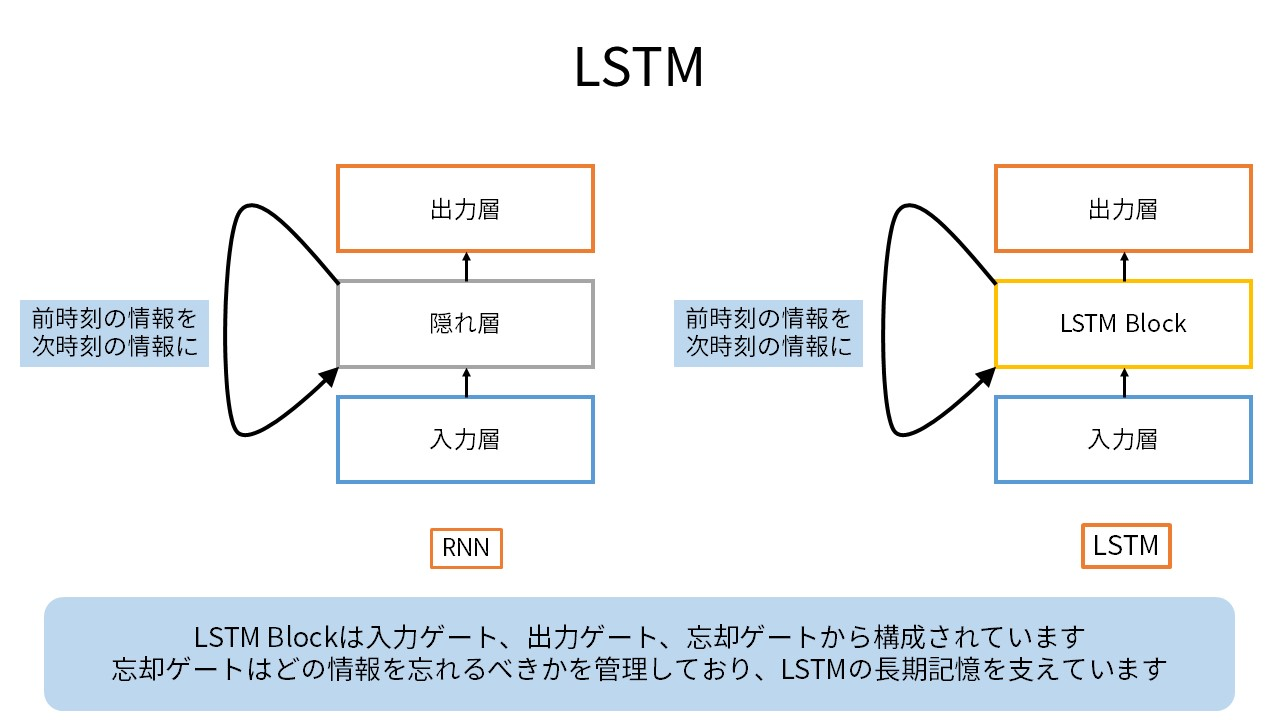



In [ ]:
#以下ではLSTMを簡便なコードで実装することを試みる。
#具体的にはサイン波の時系列予測を行う。


# --- ライブラリのインポート ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- サイン波の生成 ---
def generate_sine_wave(seq_length=400):
    x = np.arange(seq_length)
    y = np.sin(0.02 * x)
    return y.reshape(-1, 1)

# --- 入力データの整形（ウィンドウ化） ---
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# --- データ準備 ---
data = generate_sine_wave(400)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

window_size = 20
X, y = create_sequences(scaled_data, window_size)

# --- 学習／テストデータに分割 ---
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- LSTM モデルの構築 ---
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# --- 予測と逆正規化 ---
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# --- 可視化（実測 vs 予測）---
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title("LSTM Sine Wave Forecast", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.utils import plot_model

# モデル構造をPNGで保存＆表示
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=100)


**【課題】**

上記のコードを用いて、コサイン波について時系列予想を行い、結果を示せ。

# **【統合課題】**

[我が国における電力需要の推移に関する時系列データを取得](https://www.tepco.co.jp/forecast/html/download_year-j.html#2022)し、適切な前処理を行った上で、LSTMのコードに実装し、今後の需要予測を行え。またその際、実数ベースでの需要量を用いた時系列分析では不適当である理由を考察し、移動平均やvolatilityといった概念を導入し、改善を試みよ（要するに実数としての需要量をRNNやLSTMにかけるだけでは不適当ということ）。

さらに余裕がある場合には、特徴量の抽出に際して、前回用いたCNNを前置し、性能の改善を試みよ。参考としては[こちら](https://qiita.com/sugiyama404/items/49420557981b399acdf8)を参照のこと。